In [1]:
import torch
from torch import Tensor, nn
from math import ceil
from torch.autograd import Function
import os
from torch.autograd.function import Function
import triton
from typing import Optional
from copy import deepcopy
import triton.language as tl

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [2]:

def validate_contiguous(x: Tensor) -> Tensor:
    return x if x.is_contiguous() else x.contiguous()


def validate_tensor_device(x: Tensor):
    if not x.is_cuda:
        message = "Tensor must be on CUDA or TRITON_INTERPRET must be set to '1'"
        assert os.environ.get("TRITON_INTERPRET", False) == "1", message


def is_cuda_available() -> bool:
    return torch.cuda.is_available()


def get_device() -> torch.device:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.device(device)

@triton.jit()
def _linear_fwd_triton():
    ...


def _linear_fwd(x:Tensor, W:Tensor, b:Optional[Tensor] = None) -> Tensor:
    if b is not None:
        return x @ W.T + b
    return x @ W.T

@triton.jit()
def _linear_bwd_triton():
    ...


def _linear_bwd(x, W, b, grad_output):
    grad_x = grad_output @ W
    grad_W = grad_output.T @ x
    grad_b = grad_output.sum(dim=-2) if b is not None else None
    return grad_x, grad_W, grad_b


class LinearFunction(Function):
    @staticmethod
    def forward(ctx, x: Tensor, W:Tensor, b:Tensor):
        ctx.save_for_backward(x, W, b)
        return _linear_fwd(x, W, b)

    @staticmethod
    def backward(ctx, grad_output: Tensor, ):
        x, W, b = ctx.saved_tensors
        grad_x, grad_W, grad_b = _linear_bwd(x, W, b, grad_output)
        return grad_x, grad_W, grad_b


class Linear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x:Tensor) -> Tensor:
        if x.ndim > 2:
            x = validate_contiguous(x)
            new_shape = (-1, x.shape[-1])
            return LinearFunction.apply(
                x.view(new_shape),
                self.weight,
                self.bias if self.bias is not None else None,
            ).view(x.shape)
        return LinearFunction.apply(
                x,
                self.weight,
                self.bias if self.bias is not None else None,
            )



In [20]:
base_benchmark_kwargs = {
    "x_names":['M'],  # argument names to use as an x-axis for the plot
    "x_vals":[128 * i for i in range(2, 20, 10)],  # different possible values for `x_name`
    "line_arg":'provider',  # argument name whose value corresponds to a different line in the plot
    "line_vals":['triton', 'torch'],  # possible values for `line_arg``
    "line_names":["Triton", "Torch"],  # label name for the lines
    "plot_name":"linear",  # name for the plot. Used also as a file name for saving the plot.
    "args":{'N': 4096} # values for function arguments not in `x_names` and `y_name`
}

dim = base_benchmark_kwargs["args"]['N']
layer = Linear(dim, dim, bias=False).to(DEVICE)
layer_ref = nn.Linear(dim, dim, bias=False).to(DEVICE)

def fwd(x, provider):
    ### for benchmark olny!
    if provider == "torch":
        return _fwd_ref(x)
    elif provider == 'triton':
        return _fwd(x)
    else:
        raise ValueError


# def fwd(x, provider):
#     ### for benchmark olny!
#     if provider == "torch":
#         return _fwd_ref(x)
#     elif provider == 'triton':
#         return _fwd(x)
#     else:
#         raise ValueError

# from torch import autograd
# def bwd(x, provider):
#     x.requires_grad = True
#     out = fwd(x, provider)

#     loss = out.sum()
#     _fwd_provider = _fwd if provider == "triton" else _fwd_ref
#     if _fwd_provider.bias is not None:
#         inputs = (x, _fwd_provider.weight, _fwd_provider.bias)
#     else:
#         inputs = (x, _fwd_provider.weight)
#     grads_ref = autograd.grad(loss, inputs)

Running benchmark: mode='fwd', bench_kind='timing'
Running benchmark: mode='fwd', bench_kind='timing'
Running benchmark: mode='fwd', bench_kind='timing'
Running benchmark: mode='fwd', bench_kind='timing'
Running benchmark: mode='bwd', bench_kind='timing'


TypeError: LinearFunction.backward() missing 3 required positional arguments: 'x', 'W', and 'b'

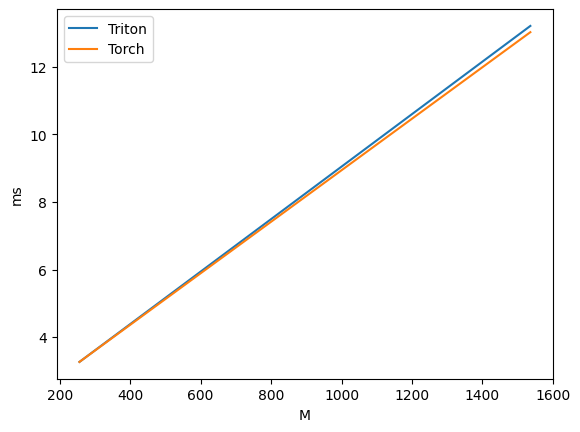

In [21]:
def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak

def benchmark_kernel(fwd, bwd, base_benchmark_kwargs):

    def bwd(x, provider):
        x.requires_grad = True
        out = fwd(x, provider)
        loss = out.sum()
        loss.backward()

    MAP_FWD_BKW = {
        "fwd" : fwd,
        "bwd" : bwd,
    }

    configs = []
    for bench_kind in ['timing', 'memory']:
        for mode in ['fwd', 'bwd']:
            _kwargs = deepcopy(base_benchmark_kwargs)
            _kwargs['args'].update({"mode" : mode})
            _kwargs['args'].update({"bench_kind" : bench_kind})
            _kwargs['ylabel'] = 'ms' if bench_kind == 'timing' else 'MB'
            _kwargs['plot_name'] += f' - {bench_kind} - {mode}'
            configs.append(triton.testing.Benchmark(**_kwargs))

    @triton.testing.perf_report(configs)
    def benchmark(M, N, provider, mode, bench_kind):
        print(f"Running benchmark: {mode=}, {bench_kind=}")
        x = torch.randn(M, N, device=DEVICE, dtype=torch.float32) # Changed dtype to float32 for debugging
        stream = getattr(torch, DEVICE.type).Stream()
        getattr(torch, DEVICE.type).set_stream(stream)
        if bench_kind == "timing":
            ms = triton.testing.do_bench(lambda: MAP_FWD_BKW[mode](x, provider))
            # gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
            return ms #gbps(ms)
        elif bench_kind == "memory":
            mem_mb = measure_memory(MAP_FWD_BKW[mode], x, provider)
            return mem_mb
        raise ValueError(f"bench_kind must be either 'timing' or 'memory', got {bench_kind}")

    result_dfs = benchmark.run(show_plots=False, print_data=False, return_df=True)
    for df, config in zip(result_dfs, configs):
        df.plot(x='N', ylabel = config.ylabel, title=config.plot_name, legend=True)

    return result_dfs

result_dfs = benchmark_kernel(fwd, bwd, base_benchmark_kwargs)